# Kaggle Miniproject 1

## Team Members:
### Karthik Karnik
### Anvita Mishra
### Kapil Sinha

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.callbacks import EarlyStopping

from keras.layers import advanced_activations
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Conv1D, MaxPooling1D, BatchNormalization, Activation, Flatten
from sklearn import tree, base
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm 

In [2]:
with open("training_data.txt") as f:
    words = f.readline().split(' ')
training_data = np.loadtxt("training_data.txt", skiprows = 1)
test_data = np.loadtxt("test_data.txt", skiprows = 1)

In [3]:
unprocessed_x_train_original = training_data[:, 1:]
y_train_original = training_data[:, 0]

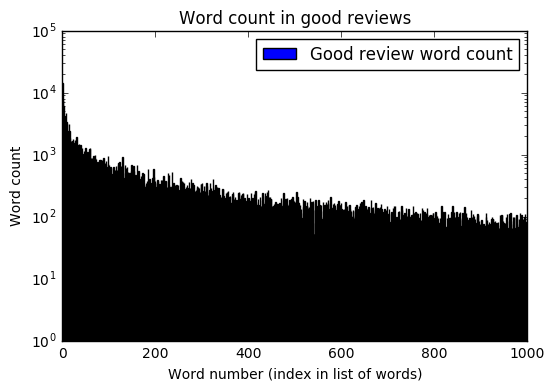

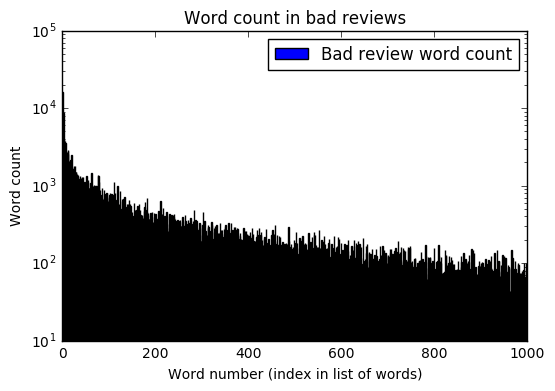

In [4]:
# Making pretty plots...not for use in submission
bad_reviews = unprocessed_x_train_original[(np.where(y_train_original == 0)[0])]
good_reviews = unprocessed_x_train_original[(np.where(y_train_original == 1)[0])]
# counts are sum of elements in columns
bad_word_counts = np.sum(bad_reviews, axis = 0)
good_word_counts = np.sum(good_reviews, axis = 0)
#print(len(bad_word_counts))
#print(len(good_word_counts))

plt.clf()
plt.title("Word count in good reviews")
plt.bar(np.arange(len(words) - 1), good_word_counts, log=True, label="Good review word count")
plt.xlabel("Word number (index in list of words)")
plt.ylabel("Word count")
plt.legend()
plt.show()

plt.title("Word count in bad reviews")
plt.bar(np.arange(len(words) - 1), bad_word_counts, log=True, label="Bad review word count")
plt.xlabel("Word number (index in list of words)")
plt.ylabel("Word count")
plt.legend()
plt.show()

Number of neutral words:  0
Neutral words:  []
Number of good words:  448
Good words sorted in order from really good to good:  ['awesom' 'excel' 'fantast' 'perfect' 'highli' 'amaz' 'solid' 'uniqu'
 'captur' 'perfectli' 'hobbit' 'delight' 'batman' 'adventur' 'tivo'
 'favorit' 'beauti' 'great' 'fascin' 'bibl' 'easi' 'appreci' 'best'
 'famili' 'journey' 'brilliant' 'love' 'heart' 'charm' 'inspir' 'jazz'
 'lover' 'fun' 'masterpiec' 'condit' 'wonder' 'soul' 'rock' 'complaint'
 'combin' 'town' 'eragon' 'tolkien' 'young' 'grow' 'tale' 'human' 'age'
 'enjoy' 'classic' 'world' 'father' 'comfort' 'collect' 'definit' 'lesson'
 'sweet' 'deep' 'mom' 'dream' 'touch' 'must' 'share' 'greatest' 'album'
 'illustr' 'quick' 'entertain' 'histori' 'summer' 'satisfi' 'magic' 'de'
 'truli' 'cultur' 'faith' 'bring' 'shoe' 'alway' 'vocal' 'eye' 'strong'
 'natur' 'earli' 'trip' 'everyon' 'glad' 'relationship' 'defin' 'beat'
 'emot' 'wow' 'fiction' 'abil' 'travel' 'life' 'live' 'hook' 'simpl'
 'recommend' 'gift'

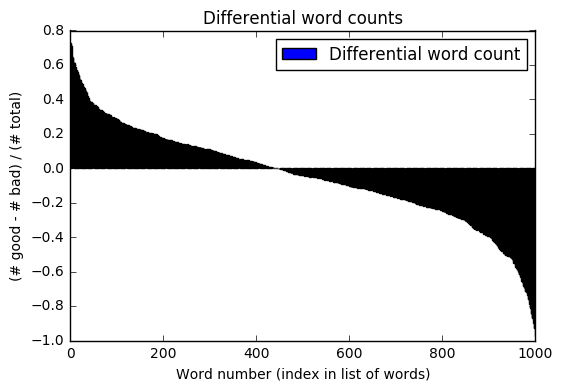

In [6]:
# for each word, differential_count = (# good - # bad) / (# total)
differential_counts = (good_word_counts - bad_word_counts) / (good_word_counts + bad_word_counts)
# words in order of decreasing differential
decreasing_differential_words = \
    np.array([x for _,x in (sorted(list(zip(differential_counts, words[1:]))))[::-1]])
decreasing_differential_counts = np.array(sorted(differential_counts)[::-1])

threshold = 0

neutral_word_indices = abs(decreasing_differential_counts) < threshold
charged_word_indices = abs(decreasing_differential_counts) >= threshold
good_word_indices = decreasing_differential_counts >= threshold
bad_word_indices = decreasing_differential_counts <= -threshold

neutral_words = decreasing_differential_words[neutral_word_indices]
charged_words = decreasing_differential_words[charged_word_indices]
good_words = decreasing_differential_words[good_word_indices]
bad_words = decreasing_differential_words[bad_word_indices]

print("Number of neutral words: ", len(neutral_words))
print("Neutral words: ", neutral_words)
print("Number of good words: ", len(good_words))
print("Good words sorted in order from really good to good: ", good_words)
print("Number of bad words: ", len(bad_words))
print("Bad words sorted in order from bad to really bad: ", bad_words)
print("Number of charged words: ", len(charged_words))
print("Charged words sorted in order from good to bad: ", charged_words)

# print("All words sorted in order from good to bad: ", decreasing_differential_words)
plt.title("Differential word counts")
plt.bar(np.arange(len(words) - 1), decreasing_differential_counts, label="Differential word count")
plt.xlabel("Word number (index in list of words)")
plt.ylabel("(# good - # bad) / (# total)")
plt.legend()
plt.show()

In [7]:
"""
Takes in a numpy array consisting of outputs for our test set and
outputs a file in the correct submission format (as per the sample
submission file)
"""
def make_submission_file(arr, fname = "submission.txt"):
    f = open(fname, 'w')
    f.write("Id,Prediction\n")
    for i in range(len(arr)):
        f.write(str(i + 1) + "," + str(arr[i]) + '\n')
    f.close()
    
"""
Normalize data by computing z score (x - mu) / std dev
and add column of ones
"""
def normalize(X):
    return X # normalizing doesn't seem to help so we don't do it
    # Normalize our input data X
    for i in range(len(X[0])):
        X[:, i] = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
    # Add column of 1s in the first column
    X = np.insert(X, 0, 1, axis=1)
    return X

"""
Calls helper functions to do all pre-processing of data
"""
def process(X, charged_word_indices):
    # Normalize counts by mean and standard deviation (z-score) and add one column
    # X = normalize (X) # seems to make the model worse?
    # Remove columns corresponding to neutral words
    X = X[:, charged_word_indices]
    return X

In [8]:
x_train_original = process(unprocessed_x_train_original, charged_word_indices)
x_test = process(test_data, charged_word_indices)

In [12]:
# Split into training and validation sets using sklearn function
# I had implemented it but it was much messier than this
x_train, x_val, y_train, y_val \
        = train_test_split(x_train_original, y_train_original, test_size = 0.2, random_state = None)
        # = train_test_split(x_train_original, y_train_original, test_size = 0.2, random_state = 1)

In [13]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(16000, 1000)
(4000, 1000)
(10000, 1000)


In [14]:
#sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sizes = [50, 60, 70]
size = 10
#for size in sizes:
# Define network


model = Sequential()
model.add(Dense(100, input_shape=(len(x_train[0]),)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))

model.add(Dense(30)) 
#model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(0.05))

model.add(Dense(30)) 
#model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(0.05))


#     model.add(Dense(25)) 
#     # model.add(BatchNormalization())
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))


# compile network
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# fit network
model.fit(x_train, y_train, epochs=10, verbose=2, validation_data = (x_val, y_val)) # verbose = 2
# Evaluate on validation set

loss, acc = model.evaluate(x_val, y_val, verbose=0)
print('Size: %d, Validation Accuracy: %f' % (size, acc*100))

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 - 3s - loss: 0.4465 - acc: 0.7996 - val_loss: 0.3471 - val_acc: 0.8500
Epoch 2/10
 - 2s - loss: 0.3355 - acc: 0.8609 - val_loss: 0.3411 - val_acc: 0.8518
Epoch 3/10
 - 2s - loss: 0.3124 - acc: 0.8717 - val_loss: 0.3398 - val_acc: 0.8550
Epoch 4/10
 - 2s - loss: 0.2902 - acc: 0.8830 - val_loss: 0.3430 - val_acc: 0.8525
Epoch 5/10
 - 2s - loss: 0.2675 - acc: 0.8953 - val_loss: 0.3503 - val_acc: 0.8552
Epoch 6/10
 - 2s - loss: 0.2463 - acc: 0.9085 - val_loss: 0.3573 - val_acc: 0.8572
Epoch 7/10
 - 2s - loss: 0.2273 - acc: 0.9161 - val_loss: 0.3605 - val_acc: 0.8572
Epoch 8/10
 - 2s - loss: 0.2103 - acc: 0.9256 - val_loss: 0.3695 - val_acc: 0.8548
Epoch 9/10
 - 2s - loss: 0.1943 - acc: 0.9318 - val_loss: 0.3786 - val_acc: 0.8542
Epoch 10/10
 - 2s - loss: 0.1782 - acc: 0.9387 - val_loss: 0.3803 - val_acc: 0.8568
Size: 10, Validation Accuracy: 85.675000


4000/4000 [==============================] - 0s 70us/step
Raw prediction scores:  [0.9915143  0.04075068 0.01141169 ... 0.9940923  0.6509376  0.00761514]
Predictions (picking raw_score >= 0.5 as positives):  [1 0 0 ... 1 1 0]
Actual y values:  [1. 0. 0. ... 1. 1. 0.]
Number of correct predictions:  3427
Number of incorrect predictions:  573


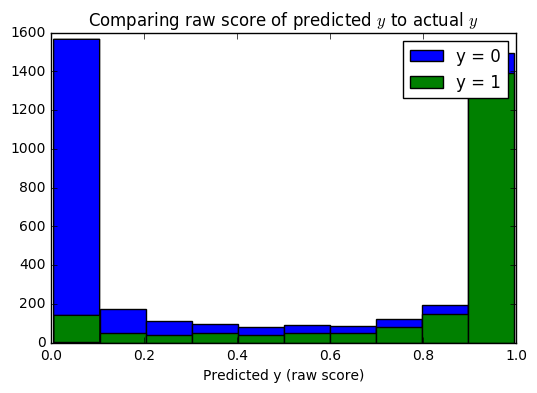

In [15]:
# Making pretty plots...not for use in submission
y_val_predictions = model.predict(x_val, verbose=1)
y_val_predictions = y_val_predictions.flatten()
lst = (y_val_predictions >= 0.5).astype(int)
print("Raw prediction scores: ", y_val_predictions)
print("Predictions (picking raw_score >= 0.5 as positives): ", lst)
print("Actual y values: ", y_val)
print("Number of correct predictions: ", (y_val == lst).sum())
print("Number of incorrect predictions: ", (y_val != lst).sum())
y_val_predictions_0 = y_val_predictions[(np.where(y_val == 0)[0])]
y_val_predictions_1 = y_val_predictions[(np.where(y_val == 1)[0])]
plt.clf()
plt.title("Comparing raw score of predicted $y$ to actual $y$")
plt.hist(np.concatenate((y_val_predictions_0, y_val_predictions_1)), stacked=True, label="y = 0")
plt.hist(y_val_predictions_1, stacked=True, label="y = 1")
plt.xlabel("Predicted y (raw score)")
plt.legend()
plt.show()

In [16]:
predictions = model.predict(x_test, verbose=1)
predictions = predictions.flatten()

10000/10000 [==============================] - 0s 50us/step


[0.8931805  0.9879181  0.07577467 ... 0.01462593 0.98459923 0.02024158]
[1 1 0 ... 0 1 0]


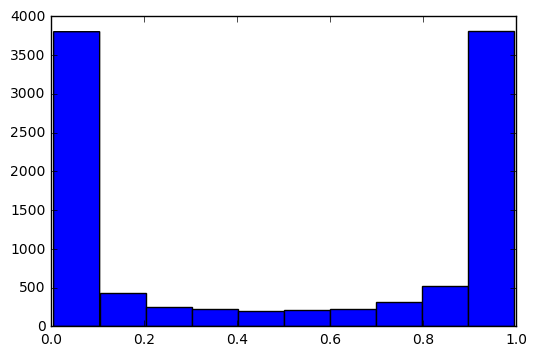

In [17]:
print(predictions)
lst = (predictions >= 0.5).astype(int)
print(lst)
plt.hist(predictions)
plt.show()

In [14]:
#print(words)

In [ ]:
make_submission_file(lst)

In [28]:
# Random forest model
x_train = training_data[:16000, 1:]
y_train = training_data[:16000, 0]

x_val = training_data[16000:, 1:]
y_val = training_data[16000:, 0]

def classification_err(y, real_y):
    """
    This function returns the classification error between two equally-sized vectors of 
    labels; this is the fraction of samples for which the labels differ.
    
    Inputs:
        y: (N, ) shaped array of predicted labels
        real_y: (N, ) shaped array of true labels
    Output:
        Scalar classification error
    """
    tot_err = 0
    
    # Count how many samples the labels differ between the two vectors
    for i in range(len(y)):
        if y[i] != real_y[i]:
            tot_err += 1
    
    # Get the fraction of samples for which the labels differ
    classification_error = float(tot_err) / len(y)
    
    return classification_error
    
def eval_tree_based_model_max_depth(clf, max_depth, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    minimum leaf size parameters in the vector min_samples_leaf, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        min_samples_leaf: a (T, ) vector of all the min_samples_leaf stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
    """
    train_err = []
    val_err = []
    
    # Use minimum leaf size parameters to create, train, and test a classifier

    # Make a new copy of the classifier, which allows us to "forget" about the
    # fitting from the previous min_leaf value
    for depth in max_depth:
        clf_copy = base.clone(clf)
        clf_copy.set_params(max_depth=depth)
        clf_copy.fit(X_train, y_train)

        train_predict = clf_copy.predict(X_train)
        test_predict = clf_copy.predict(X_test)

        train_err.append(classification_err(train_predict, y_train))
        val_err.append(classification_err(test_predict, y_test))

    return train_err, val_err



n_estimators = 200
clf = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini')

max_depth = [70]

#max_depth = np.arange(10, 51)

train_err, test_err = eval_tree_based_model_max_depth(clf, max_depth, x_train, y_train, x_val, y_val)

train_accuracy = 1 - train_err[0]
test_accuracy = 1 - test_err[0]

print(train_accuracy)
print(test_accuracy)

KeyboardInterrupt: 

In [30]:
def random_forest_predict(clf, max_depth, X_train, y_train, X_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    minimum leaf size parameters in the vector min_samples_leaf, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        min_samples_leaf: a (T, ) vector of all the min_samples_leaf stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
    """
    train_err = []
    val_err = []
    
    # Use minimum leaf size parameters to create, train, and test a classifier

    # Make a new copy of the classifier, which allows us to "forget" about the
    # fitting from the previous min_leaf value
    clf_copy = base.clone(clf)
    clf_copy.set_params(max_depth= max_depth)
    clf_copy.fit(X_train, y_train)

    train_predict = clf_copy.predict(X_train)
    test_predict = clf_copy.predict(X_test)

    train_err.append(classification_err(train_predict, y_train))

    return train_err, test_predict

train_err, test_predict = random_forest_predict(clf, 49, x_train, y_train, x_test)

print(train_err)

print(test_predict)

KeyboardInterrupt: 

In [144]:
test_predict.astype(int)

array([1, 1, 0, ..., 0, 1, 0])

In [31]:
plt.figure()
plt.plot(max_depth, test_err, label='Testing error')
plt.plot(max_depth, train_err, label='Training error')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Validation error')
plt.title('Decision Tree with Gini Impurity and Maximum Tree Depth')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at max_depth = %i' % max_depth[np.argmin(test_err)])

NameError: name 'test_err' is not defined

In [145]:
make_submission_file(test_predict.astype(int))

In [133]:
print(len(test_predict))

10000


3 models, have each of them vote

output is 1 if good, 0 if bad 

pool the data, choose 

In [ ]:
def neural_network(x_train, y_train, x_val, y_val):
    "Fits a neural network"
    model = Sequential()
    model.add(Dense(100, input_shape=(len(x_train[0]),)))
    model.add(Activation('relu'))
    model.add(Dropout(0.05))

    model.add(Dense(30)) 
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.05))

    model.add(Activation('sigmoid'))
    model.add(Dropout(0.05))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # compile network
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # fit network
    model.fit(x_train, y_train, epochs=10, verbose=2, validation_data = (x_val, y_val)) # verbose = 2
    loss, acc = model.evaluate(x_val, y_val, verbose=0)
    
    # Evaluate on validation set
    y_val_nt = model.predict(x_val, verbose=1)
    y_val_nt = y_val_nt.flatten()
    y_val_nt = (y_val_nt >= 0.5).astype(int)
    
    print('Neural Network Results:')
    print('Size: %d, Validation Accuracy: %f' % (size, acc*100))
    
    return loss, y_val_nt

In [57]:
def SVC(x_train, y_train, x_val, y_val):
    clf = svm.SVC()
    clf.fit(x_train, y_train, verbose=1)
    #y_val_SVC = clf.predict(x_val)
    loss_SVC = clf.score(x_val, y_val) 
    
    return loss_SVC#, y_val_SVC

In [60]:
clf = svm.SVC(verbose=1)
clf.fit(x_train, y_train)
#y_val_SVC = clf.predict(x_val)
loss_SVC = clf.score(x_val, y_val)

[LibSVM]

KeyboardInterrupt: 

In [36]:
loss, y_val_nt = neural_network(x_train, y_train, x_val, y_val)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 - 4s - loss: 0.5411 - acc: 0.7774 - val_loss: 0.4361 - val_acc: 0.8562
Epoch 2/10
 - 2s - loss: 0.4152 - acc: 0.8553 - val_loss: 0.3856 - val_acc: 0.8568
Epoch 3/10
 - 2s - loss: 0.3757 - acc: 0.8678 - val_loss: 0.3712 - val_acc: 0.8565
Epoch 4/10
 - 2s - loss: 0.3540 - acc: 0.8745 - val_loss: 0.3652 - val_acc: 0.8540
Epoch 5/10
 - 2s - loss: 0.3394 - acc: 0.8803 - val_loss: 0.3653 - val_acc: 0.8548
Epoch 6/10
 - 2s - loss: 0.3259 - acc: 0.8864 - val_loss: 0.3656 - val_acc: 0.8565
Epoch 7/10
 - 2s - loss: 0.3111 - acc: 0.8921 - val_loss: 0.3677 - val_acc: 0.8525
Epoch 8/10
 - 2s - loss: 0.2977 - acc: 0.9010 - val_loss: 0.3722 - val_acc: 0.8555
Epoch 9/10
 - 2s - loss: 0.2829 - acc: 0.9073 - val_loss: 0.3769 - val_acc: 0.8530
Epoch 10/10
 - 2s - loss: 0.2685 - acc: 0.9136 - val_loss: 0.3812 - val_acc: 0.8518
4000/4000 [==============================] - 1s 126us/step
Neural Network Results:
Size: 10, Validation Accuracy: 85.175

In [41]:
loss_rf, y_val_rf = random_forest_predict(clf, 49, x_train, y_train, x_test)

In [42]:
len(y_val_rf)

10000

In [47]:
def ensemble_model(x_train, y_train, x_val, y_val):
    """
    This function generates an ensemble with three models: 
        (1) SVC with RBF Kernel
        (2) Random Forest Classfier
        (3) Neural network
    
    """
    loss, y_val_nt = neural_network(x_train, y_train, x_val, y_val)
    print("Neural Network finished")
    
    loss_rf, y_val_rf = random_forest_predict(clf, 49, x_train, y_train, x_val)
    print("Random Forest finished")
    
    loss_SVC, y_val_SVC = SVC(x_train, y_train, x_val, y_val)
    print("SVC finished")
       
    # Combining the y classification errors
    df_results = pd.DataFrame(columns = [ 'y_val_neural', 'y_val_rf', "y_val_SVC"])
    
    #df_results['correct_y'] = y_val
    df_results['y_val_neural'] = y_val_nt 
    df_results['y_val_rf'] = y_val_rf
    df_results["y_val_SVC"] = y_val_SVC 
    
    for i in np.arange(len(df_results)):
        pooled = np.zeros(len(df_results))
        pooled[i] = scipy.stats.mode(df_results[i])
        
    df_results["combined"] = pooled
    df_results['correct_y_val'] = y_val
    df_results['correctly_classified'] = (df_results.combined==df_results.correct_y_val).astype(int)
    
    return df_results

In [48]:
x_train, x_val, y_train, y_val \
        = train_test_split(x_train_original, y_train_original, test_size = 0.2, random_state = None)
df_final = ensemble_model(x_train, y_train, x_val, y_val)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 - 3s - loss: 0.5288 - acc: 0.7861 - val_loss: 0.4425 - val_acc: 0.8390
Epoch 2/10
 - 2s - loss: 0.4092 - acc: 0.8594 - val_loss: 0.3988 - val_acc: 0.8440
Epoch 3/10
 - 2s - loss: 0.3704 - acc: 0.8687 - val_loss: 0.3839 - val_acc: 0.8462
Epoch 4/10
 - 3s - loss: 0.3497 - acc: 0.8742 - val_loss: 0.3796 - val_acc: 0.8400
Epoch 5/10
 - 2s - loss: 0.3333 - acc: 0.8799 - val_loss: 0.3813 - val_acc: 0.8433
Epoch 6/10
 - 2s - loss: 0.3199 - acc: 0.8864 - val_loss: 0.3811 - val_acc: 0.8385
Epoch 7/10
 - 2s - loss: 0.3015 - acc: 0.8962 - val_loss: 0.3822 - val_acc: 0.8440
Epoch 8/10
 - 2s - loss: 0.2841 - acc: 0.9024 - val_loss: 0.3851 - val_acc: 0.8420
Epoch 9/10
 - 2s - loss: 0.2695 - acc: 0.9128 - val_loss: 0.3943 - val_acc: 0.8375
Epoch 10/10
 - 2s - loss: 0.2519 - acc: 0.9193 - val_loss: 0.4032 - val_acc: 0.8415
4000/4000 [==============================] - 0s 94us/step
Neural Network Results:
Size: 10, Validation Accuracy: 84.1500

KeyboardInterrupt: 

In [34]:
df_final

NameError: name 'df_final' is not defined